<a href="https://colab.research.google.com/github/digo-eu/advanced_learning/blob/main/microdados_violencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Usado para baixar a base como microdados_violencia.csv:</h3>
   pip install basedosdados <br>
   import basedosdados as bd <br>
   df = bd.read_table(dataset_id='br_ms_sinan', table_id='microdados_violencia', billing_project_id="violenciasinan", use_bqstorage_api = True) <br>
   df.to_csv(path_or_buf = 'microdados_violencia.csv')

<b>Incluído para simples referência à origem dos dados. Eles já estão incluídos no repositório por meio do Git LFS com o nome <i>"microdados_violencia.csv"</i>.</b> <br>
Necessário criar projeto do Google Big Query para que seja feita a conexão com a base original.

In [9]:
# importar bibliotecas usadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', 100)
from sklearn.metrics import confusion_matrix, classification_report
import itertools
print(tf.__version__)
try:
   physical_devices = tf.config.list_physical_devices('GPU') 
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
   for device in physical_devices:
      tf.config.experimental.set_memory_growth(device, True)
      print(physical_devices)
except:
   print("No GPU")

2.11.0
No GPU


In [10]:
df = pd.read_csv('microdados_violencia.csv')
df.head()

,Unnamed: 0,ano,data_notificacao,id_categoria_cid10,id_subcategoria_cid10,tipo_notificacao,id_uf_notificacao,id_municipio_notificacao,id_municipio_6_notificacao,id_unidade_notificacao,id_regional_saude_notificacao,data_ocorrencia,id_uf_ocorrencia,id_municipio_ocorrencia,id_municipio_6_ocorrencia,hora_ocorrencia,local_ocorrencia,outro_local_ocorrencia,outras_vezes_ocorrencia,id_uf_residencia,id_municipio_residencia,id_municipio_6_residencia,id_regional_saude_residencia,idade_paciente,sexo_paciente,gestante_paciente,raca_paciente,escolaridade_paciente,ocupacao_paciente,estado_civil_paciente,orientacao_sexual_paciente,identidade_genero_paciente,motivacao_violencia,violencia_relacionada_trabalho,emitiu_cat,deficiencia_transtorno_paciente,deficiencia_fisica_paciente,deficiencia_mental_paciente,deficiencia_visual_paciente,deficiencia_auditiva_paciente,transtorno_mental_paciente,transtorno_comportamental_paciente,outras_deficiencias_paciente,quais_outras_deficiencias_paciente,lesao_autoprovocada,ocorreu_violencia_fisica,ocorreu_violencia_psicologica,ocorreu_tortura,ocorreu_violencia_sexual,ocorreu_trafico_ser_humano,...,houve_estupro,houve_pornografia_infantil,houve_exploracao_sexual,houve_outra_violencia_sexual,houve_qual_outra_violencia_sexual,profilaxia_dst,profilaxia_hiv,profilaxia_hepatite_b,coleta_sangue,coleta_semen,coleta_secrecao_vaginal,profilaxia_contraceptivo,aborto,numero_envolvidos_violencia,autor_pai,autor_mae,autor_padrasto,autor_madrasta,autor_conjugue,autor_ex_conjugue,autor_namorado_a,autor_ex_namorado_a,autor_filho_a,autor_desconhecido,autor_irmao,autor_conhecido,autor_cuidador,autor_patrao_chefe,autor_institucional,autor_policial,autor_propria_pessoa,autor_outros,autor_relacao_outros,autor_sexo,autor_usou_alcool,encaminhamento_saude,encaminhamento_assistencia_social,encaminhamento_educacao,encaminhamento_atendimento_mulher,encaminhamento_conselho_tutelar,encaminhamento_conselho_idoso,encaminhamento_delegacia_idoso,encaminhamento_direitos_humanos,encaminhamento_mpu,encaminhamento_delegacia_crianca,encaminhamento_delegacia_mulher,encaminhamento_delegacia,encaminhamento_justica_infancia_juventude,encaminhamento_defensoria_publica,data_encerramento
0,0,2009,2009-11-03,Y09,Y00.4,2,12,1200104.0,120010,2001500.0,1937.0,2009-11-03,12.0,1200104.0,120010,02:30:00,6.0,NaN,0.0,12,1200104.0,120010,1937.0,26.0,1.0,6.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,...,8.0,8.0,8.0,8.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2009-11-04
1,1,2009,2009-02-04,Y09,NaN,2,27,2700300.0,270030,3015408.0,1537.0,2009-02-04,27.0,2700300.0,270030,17:58:00,NaN,NaN,NaN,27,2700300.0,270030,1537.0,27.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2009-02-04
2,2,2009,2009-03-18,Y09,NaN,2,27,2700300.0,270030,3015408.0,1537.0,2009-03-18,27.0,2700706.0,270070,08:00:00,1.0,NaN,0.0,27,2700706.0,270070,1538.0,20.0,1.0,6.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-03-20
3,3,2009,2009-03-31,Y09,NaN,2,27,2700300.0,270030,3015408.0,1537.0,2009-03-31,27.0,2709152.0,270915,00:30:00,NaN,NaN,NaN,27,2709152.0,270915,1545.0,16.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Resumo dos dados e objetivos de pesquisa

Nossos dados têm origem no questionário de violência interpessoal ou autoprovocada do SINAN, aplicado em usuários da rede de saúde que se apresentam como casos suspeitos ou confirmados de violência doméstica/intrafamiliar ou extrafamiliar caso a vítima seja criança, adolescente, mulher, idosa, indígena, LGBT ou pessoa com deficiência ou transtorno.

Dentre as perguntas do questionário estão vários fatores que, imaginamos, representam um diferencial de risco quanto a diferentes características dessa violência sofrida, sejam: letalidade, repetição, caráter sexual, entre outras.

A grande quantidade de dados disponíveis nessa base nos levam a crer que seria possível determinar a relação de várias dessas respostas ao questionário com as características mais relevantes da violência sofrida, a fim de traçar um perfil e mais facilmente detectar casos de violência em um cenário de cuidado real, em que vítimas de violência frequentemente escondem a situação por que estão passando.

Demos preferência a uma característica em particular: a reincidência do caso de violência.
Essa característica se apresenta no questionário em forma binária, na forma da pergunta "Ocorreu outras vezes?" para a qual se pode responder "sim", "não" ou "ignorado".

Trata-se portanto de um problema de classificação binária, em que se quer predizer a probabilidade que um indivíduo com dadas características tem de sofrer de violência interpessoal ou autoprovocada repetida. Devemos portanto optar por modelos adequados para essa tarefa. A título de comparação do desempenho, escolhemos:

*   Naive Bayes
*   Regressão Logística
*   K-Nearest Neighbours
*   Support Vector Machine
*   Árvore Decisória
*   Bagging Decision Tree (Ensemble Learning I)
*   Boosted Decision Tree (Ensemble Learning II)
*   Random Forest (Ensemble Learning III)
*   Voting Classification (Ensemble Learning IV)
*   Rede Neural (Deep Learning)

Iremos avaliar a qualidade dos resultados para selecionar o melhor modelo para nossa análise.

## Visualização e tratamento dos dados

A base de dados utilizada contém uma grande quantidade de colunas, com diversos tipos de dados entre elas. Alguns desses dados são pouco úteis para a nossa análise e precisamos avaliá-los e filtrá-los.

In [11]:
# excluir colunas inadequadas para a análise (tornado opcional por enquanto)
df = df.drop(['data_encerramento', 'data_notificacao', 'id_categoria_cid10', 'id_subcategoria_cid10', 'data_ocorrencia', 'hora_ocorrencia', 'id_municipio_notificacao', 'id_municipio_6_notificacao', 'id_unidade_notificacao','id_regional_saude_notificacao', 'id_municipio_ocorrencia', 'id_municipio_6_ocorrencia', 'id_municipio_residencia', 'id_municipio_6_residencia', 'id_regional_saude_residencia','houve_qual_outra_violencia_sexual', 'meio_qual_outro', 'ocorreu_qual_outra', 'outro_local_ocorrencia', 'quais_outras_deficiencias_paciente', 'autor_relacao_outros'], axis=1)

# resumo dos dados
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

,Unnamed: 0,ano,tipo_notificacao,id_uf_notificacao,id_uf_ocorrencia,local_ocorrencia,outras_vezes_ocorrencia,id_uf_residencia,idade_paciente,sexo_paciente,gestante_paciente,raca_paciente,escolaridade_paciente,ocupacao_paciente,estado_civil_paciente,orientacao_sexual_paciente,identidade_genero_paciente,motivacao_violencia,violencia_relacionada_trabalho,emitiu_cat,deficiencia_transtorno_paciente,deficiencia_fisica_paciente,deficiencia_mental_paciente,deficiencia_visual_paciente,deficiencia_auditiva_paciente,transtorno_mental_paciente,transtorno_comportamental_paciente,outras_deficiencias_paciente,lesao_autoprovocada,ocorreu_violencia_fisica,ocorreu_violencia_psicologica,ocorreu_tortura,ocorreu_violencia_sexual,ocorreu_trafico_ser_humano,ocorreu_violencia_financeira,ocorreu_negligencia_abandono,ocorreu_trabalho_infantil,ocorreu_intervencao_legal,ocorreu_outra_violencia,meio_forca,meio_enforcamento,meio_objeto_contundente,meio_objeto_perfurante,meio_objeto_quente,meio_envenenamento,meio_arma_fogo,meio_ameaca,meio_outros,houve_assedio,houve_estupro,houve_pornografia_infantil,houve_exploracao_sexual,houve_outra_violencia_sexual,profilaxia_dst,profilaxia_hiv,profilaxia_hepatite_b,coleta_sangue,coleta_semen,coleta_secrecao_vaginal,profilaxia_contraceptivo,aborto,numero_envolvidos_violencia,autor_pai,autor_mae,autor_padrasto,autor_madrasta,autor_conjugue,autor_ex_conjugue,autor_namorado_a,autor_ex_namorado_a,autor_filho_a,autor_desconhecido,autor_irmao,autor_conhecido,autor_cuidador,autor_patrao_chefe,autor_institucional,autor_policial,autor_propria_pessoa,autor_outros,autor_sexo,autor_usou_alcool,encaminhamento_saude,encaminhamento_assistencia_social,encaminhamento_educacao,encaminhamento_atendimento_mulher,encaminhamento_conselho_tutelar,encaminhamento_conselho_idoso,encaminhamento_delegacia_idoso,encaminhamento_direitos_humanos,encaminhamento_mpu,encaminhamento_delegacia_crianca,encaminhamento_delegacia_mulher,encaminhamento_delegacia,encaminhamento_justica_infancia_juventude,encaminhamento_defensoria_publica
0,0,2009,2,12,12.0,6.0,0.0,12,26.0,1.0,6.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,1,2009,2,27,27.0,NaN,NaN,27,27.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299140,2299140,2016,2,33,33.0,1.0,1.0,33,11.0,0.0,5.0,4.0,3.0,999991.0,1.0,1.0,8.0,88.0,0.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299141,2299141,2016,2,33,33.0,1.0,0.0,33,17.0,1.0,6.0,2.0,3.0,NaN,NaN,1.0,8.0,NaN,0.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.isnull().sum()

Unnamed: 0                                        0
ano                                               0
tipo_notificacao                                  0
id_uf_notificacao                                 0
id_uf_ocorrencia                              62334
                                              ...  
encaminhamento_delegacia_crianca             321435
encaminhamento_delegacia_mulher              316273
encaminhamento_delegacia                     867018
encaminhamento_justica_infancia_juventude    865958
encaminhamento_defensoria_publica            868778
Length: 96, dtype: int64

Uma parte significativa de 3 das colunas acima apresentam valor nulo - podemos considerar a possibilidade de excluí-las ou manter para análise.
Optamos por substituir esses valores nulos por 0, de modo a considerar que respostas não dadas são equivalentes a uma resposta negativa às perguntas.

In [13]:
# NaN em 0
df = df.replace (np.nan, 0)

In [14]:
# separando labels e features
feature = df.copy()
label = feature.pop('outras_vezes_ocorrencia')

In [15]:
label.value_counts()

0.0    1517983
1.0     781159
Name: outras_vezes_ocorrencia, dtype: int64

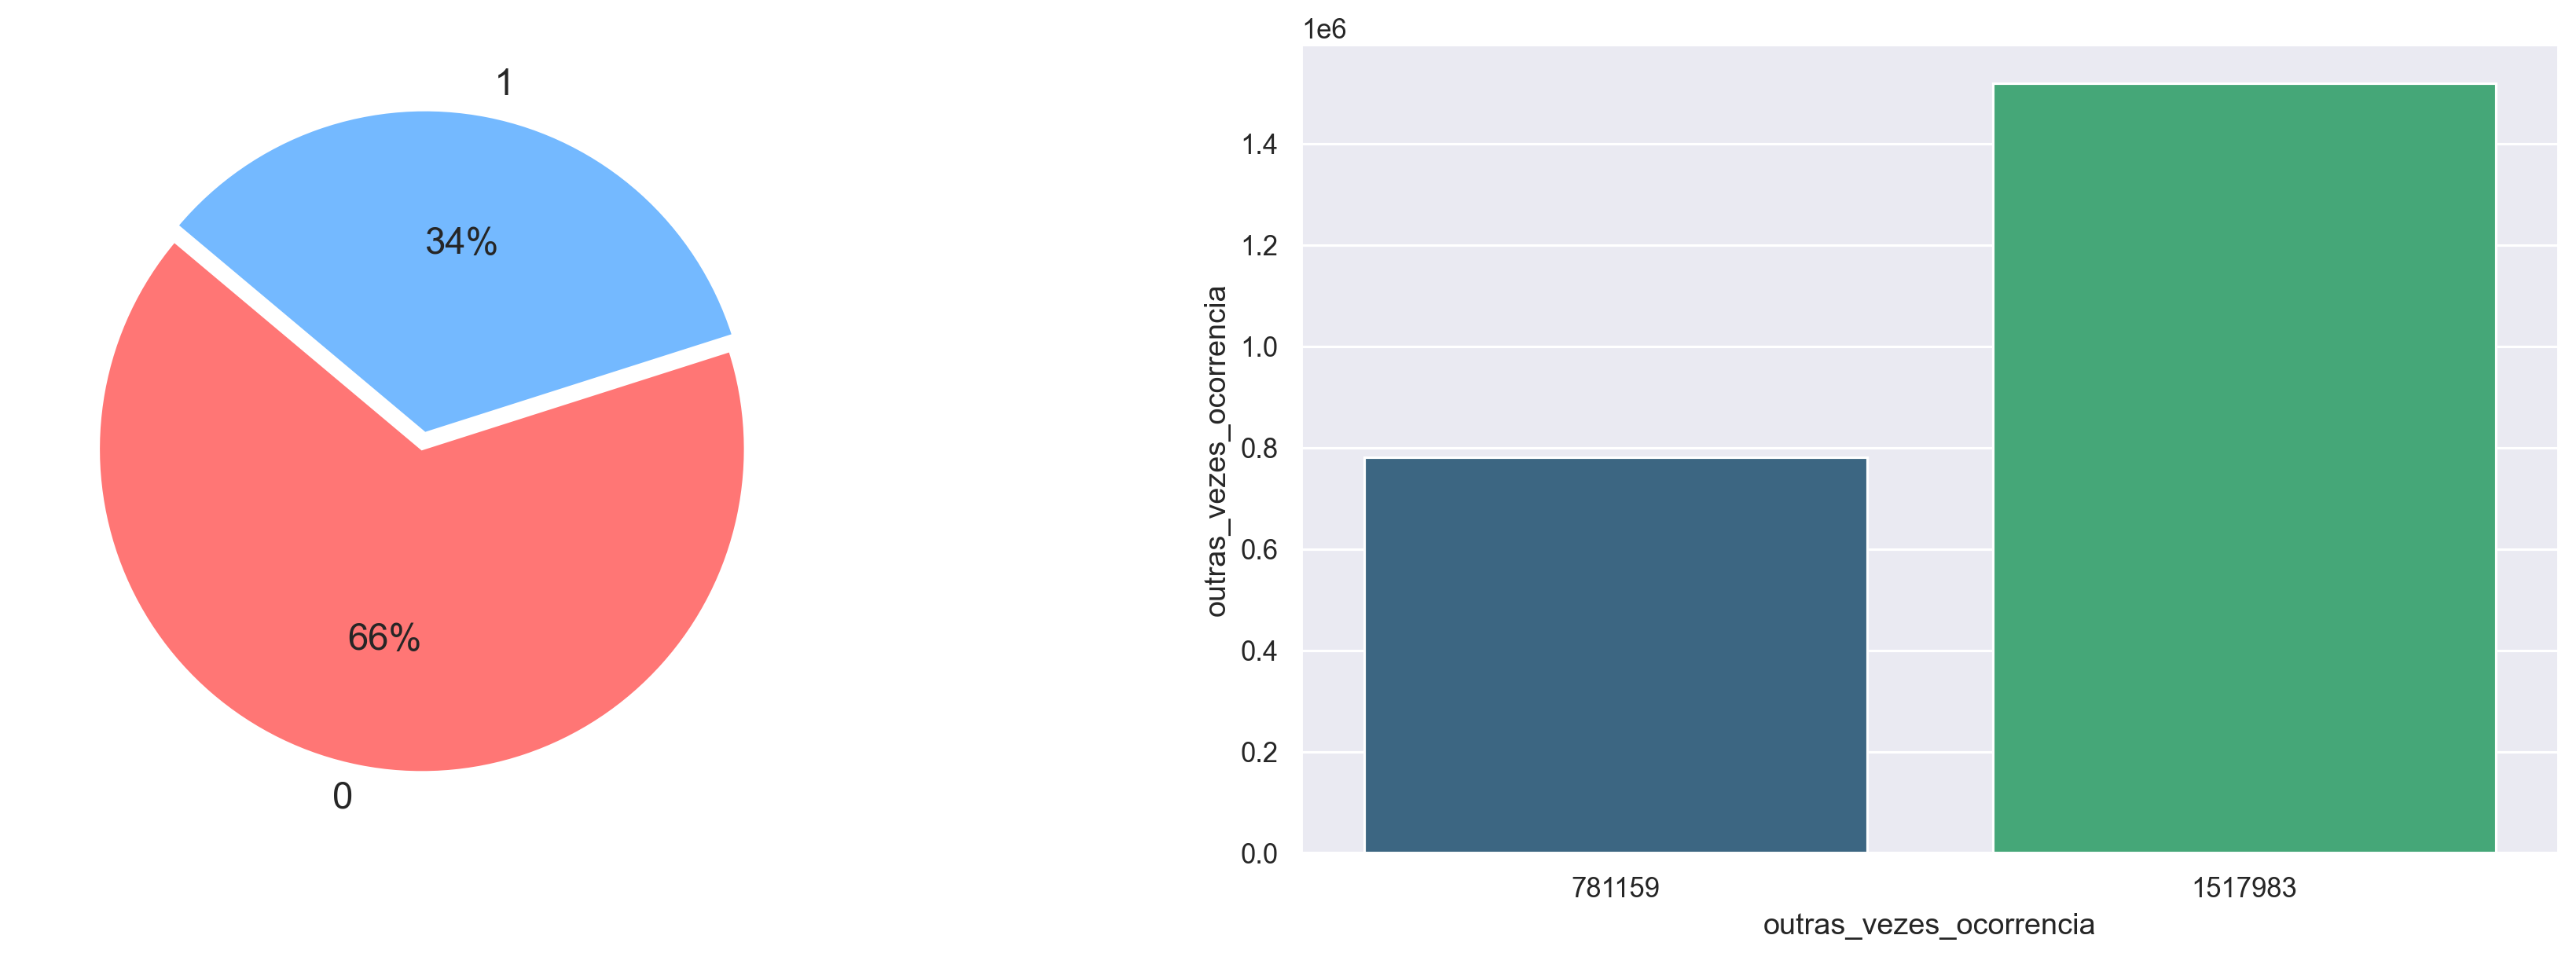

In [16]:
labels = [0,1]
sizes = [1517983, 781159]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = label.value_counts(), y = label.value_counts(), palette= 'viridis')

plt.show()

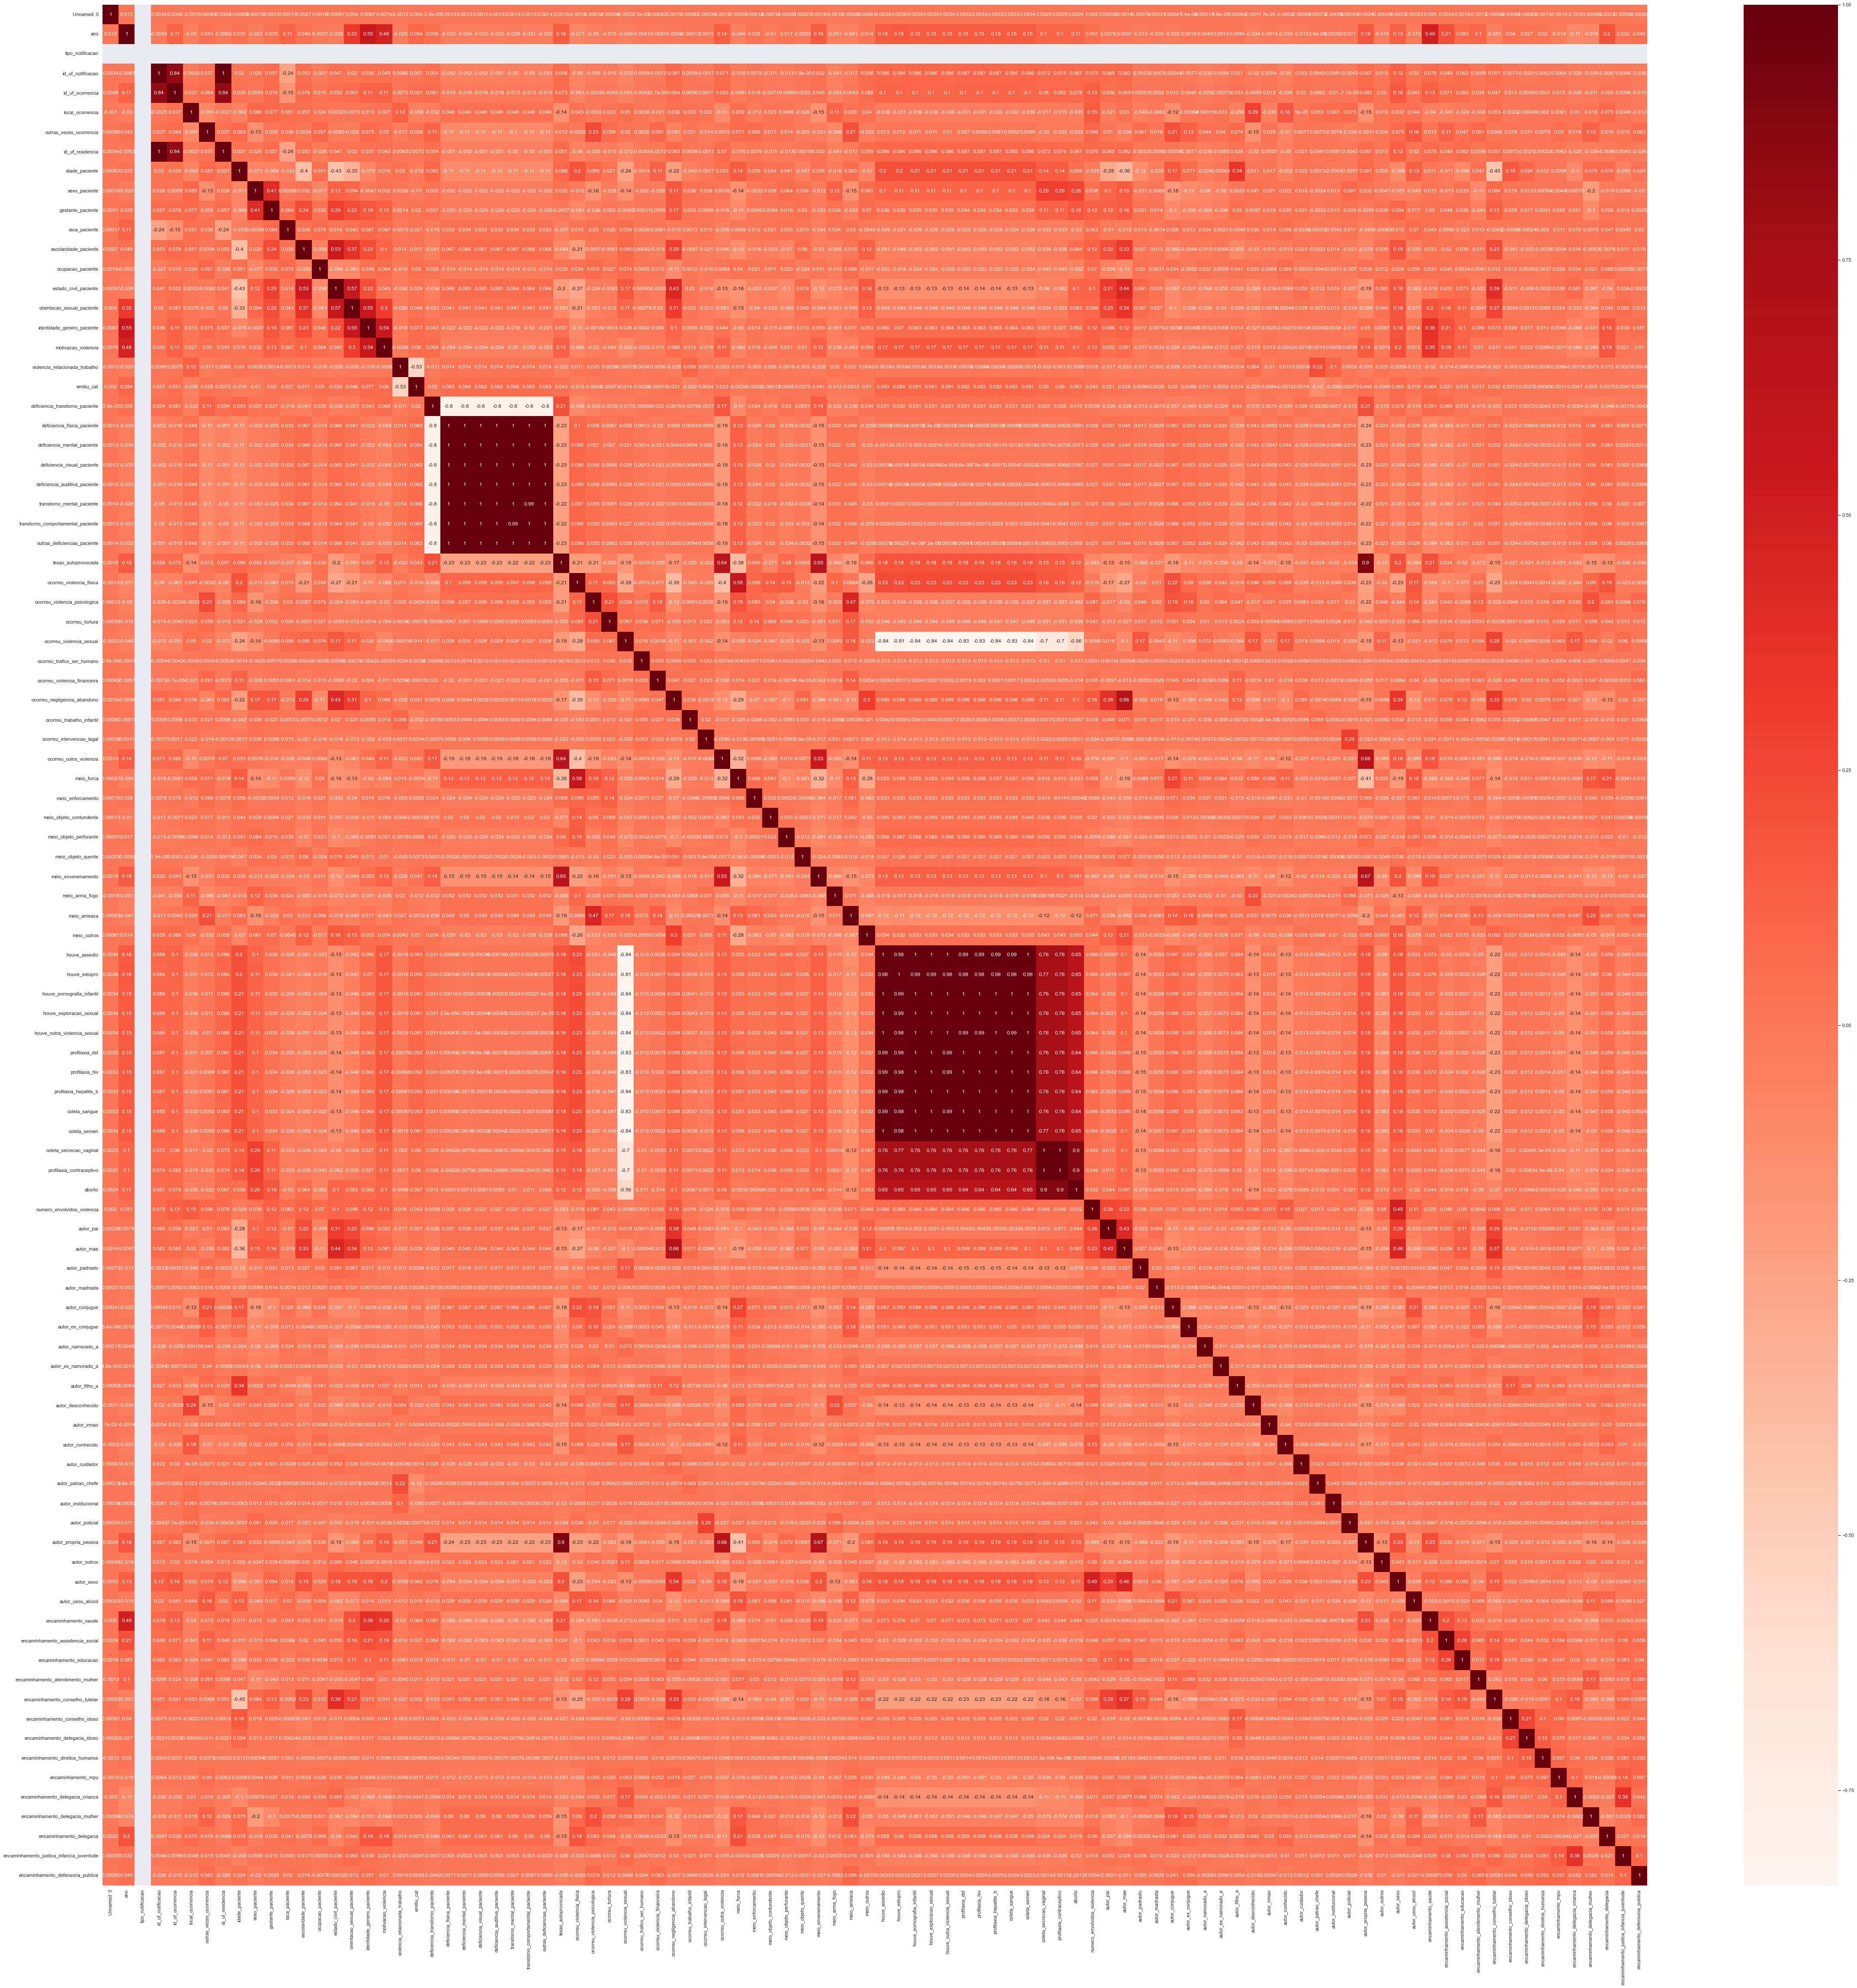

In [17]:
plt.figure(figsize=(80,80))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

Xtreino, Xteste, Ytreino, Yteste=train_test_split(feature, label, test_size=0.6, shuffle=True, random_state=0)

In [19]:
# definindo funções de avaliação dos modelos

# teste de mean average percentage error
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    return mape

# função de avaliação dos resultados do modelo
def train_model(model):
    model.fit(Xtreino, Ytreino)
    Ypred = model.predict(Xteste)
    Yprob = model.predict_proba(Xteste)
    accuracy = round(accuracy_score(Yteste, Ypred), 3)
    precision = round(precision_score(Yteste, Ypred), 3)
    recall = round(recall_score(Yteste, Ypred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(Yteste, Ypred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(Yteste, Yprob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

Accuracy of the model: 0.574
Precision Score of the model: 0.394
Recall Score of the model: 0.471


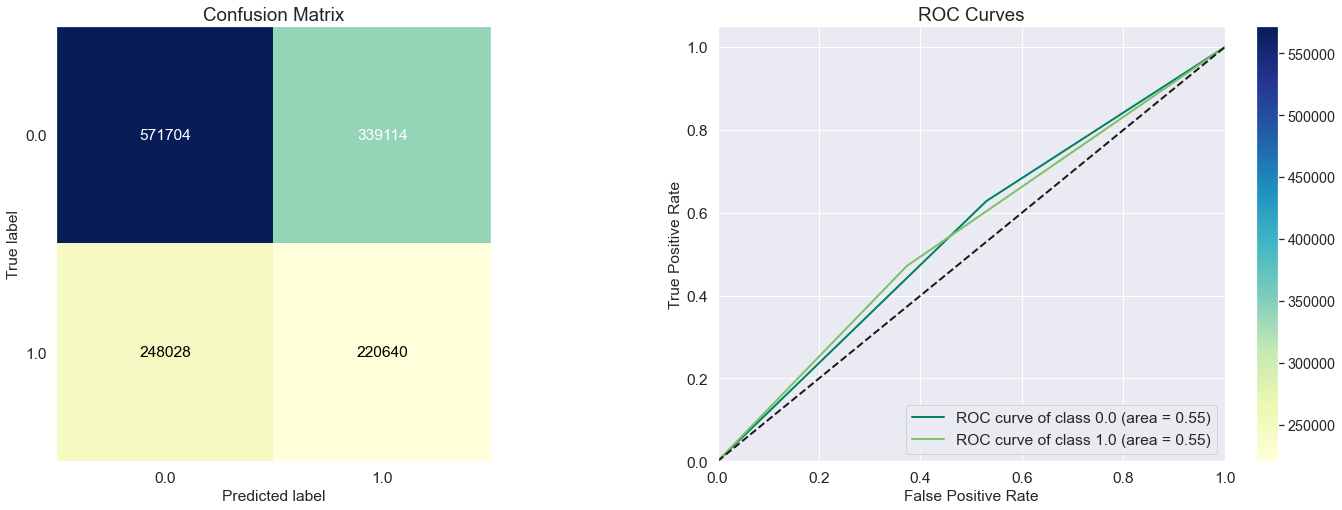

In [20]:
nb = MultinomialNB()
train_model(nb)

O modelo Naive Bayes teve baixa acurácia, baixa precisão e baixo recall.

Accuracy of the model: 0.733
Precision Score of the model: 0.649
Recall Score of the model: 0.463


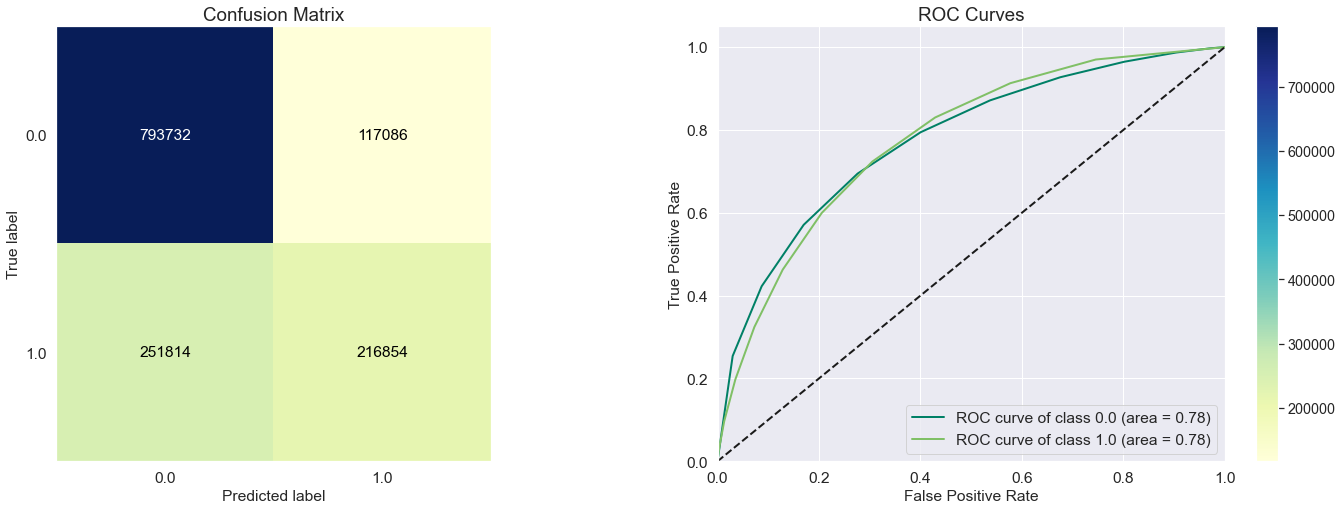

In [22]:
rf = RandomForestClassifier(n_estimators= 10)
train_model(rf)

O modelo Random Forests apresentou acurácia e precisão melhores que o Naive Bayes, mas recall não mudou significativamente.

Accuracy of the model: 0.66
Precision Score of the model: 0.471
Recall Score of the model: 0.0


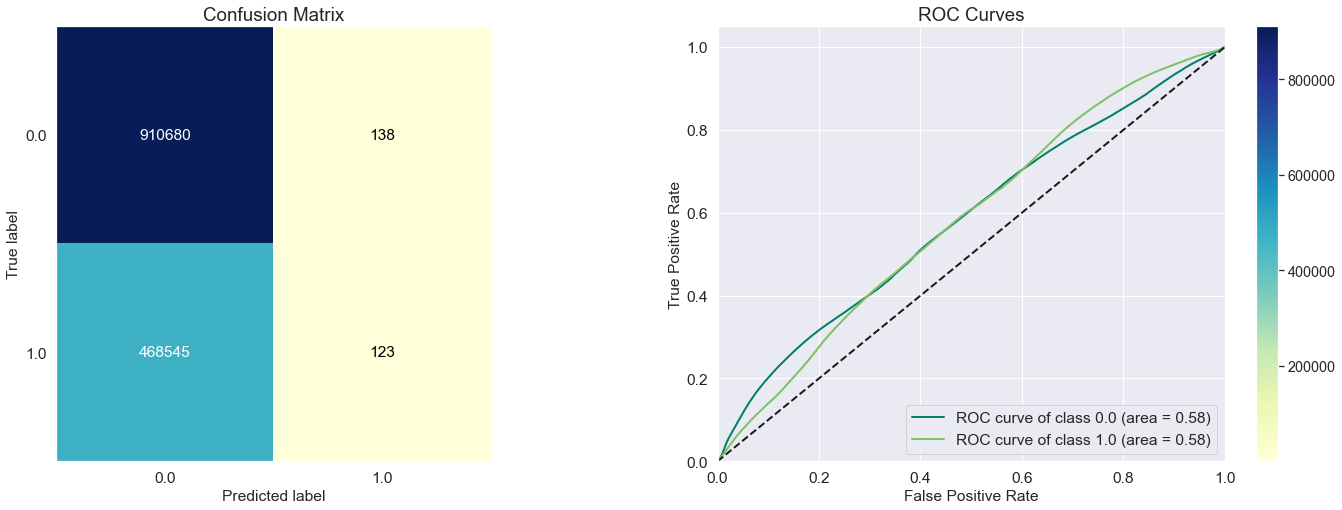

In [23]:
lr = LogisticRegression()
train_model(lr)

In [ ]:
dtree = DecisionTreeClassifier()
train_model(dtree)

Accuracy of the model: 0.756
Precision Score of the model: 0.669
Recall Score of the model: 0.558


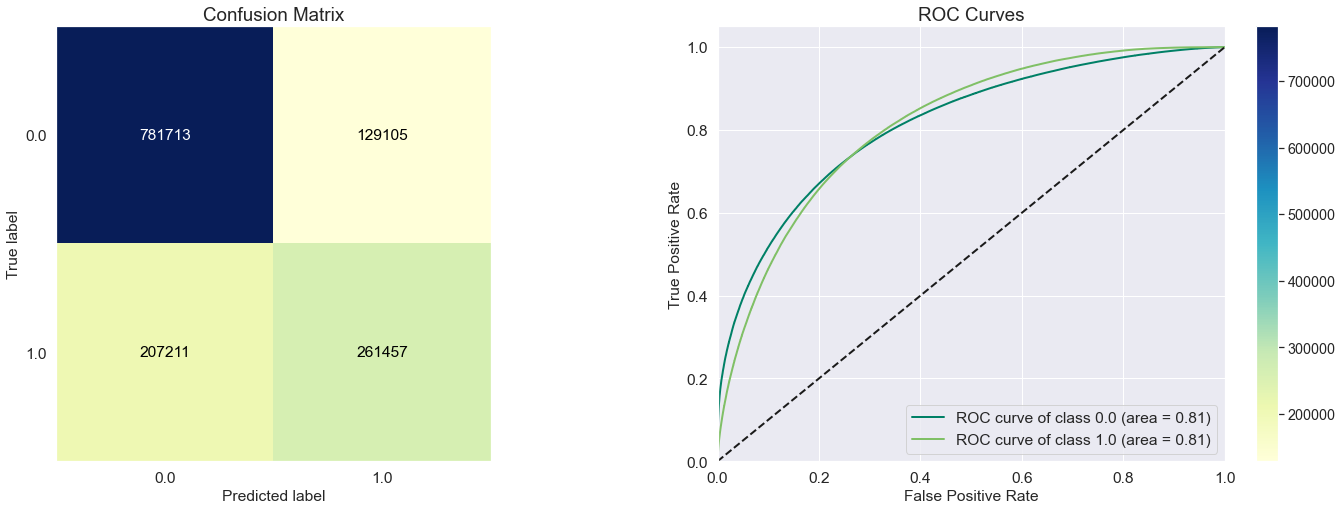

In [33]:
xgb = XGBClassifier()
train_model(xgb)

O modelo de árvore decisória apresentou o melhor recall até o momento.

In [ ]:
# agrupando modelos
estimator = []
estimator.append(('LR', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 50)))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('DTC', DecisionTreeClassifier()))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(Xtreino, Ytreino)
Y_prediction = vot_hard.predict(Xteste)

# using accuracy_score metric to predict accuracy
score = accuracy_score(Yteste, Y_prediction)
print("Hard Voting Score % d" % score)

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(Xtreino, Ytreino)
Y_prediction = vot_soft.predict(Xteste)

# using accuracy_score
score = accuracy_score(Yteste, Y_prediction)
print("Soft Voting Score % d" % score)

Naive Bayes:
Accuracy of the model: 0.574
Precision Score of the model: 0.394
Recall Score of the model: 0.471

Random Forest:
Accuracy of the model: 0.732
Precision Score of the model: 0.649
Recall Score of the model: 0.462

LogisticRegression:
Accuracy of the model: 0.66
Precision Score of the model: 0.471
Recall Score of the model: 0.0

Árvore Decisória:
Accuracy of the model: 0.67
Precision Score of the model: 0.514
Recall Score of the model: 0.523

XGBClassifier:
Accuracy of the model: 0.756
Precision Score of the model: 0.669
Recall Score of the model: 0.558

X   Naive Bayes
X   Regressão Logística
X   Random Forest (Ensemble Learning III)
X   Árvore Decisória
*   K-Nearest Neighbours
*   Support Vector Machine
*   Bagging Decision Tree (Ensemble Learning I)
*   Boosted Decision Tree (Ensemble Learning II)
*   Voting Classification (Ensemble Learning IV)
*   Rede Neural (Deep Learning)

Text(0.5, 1.0, 'Feature Importance')

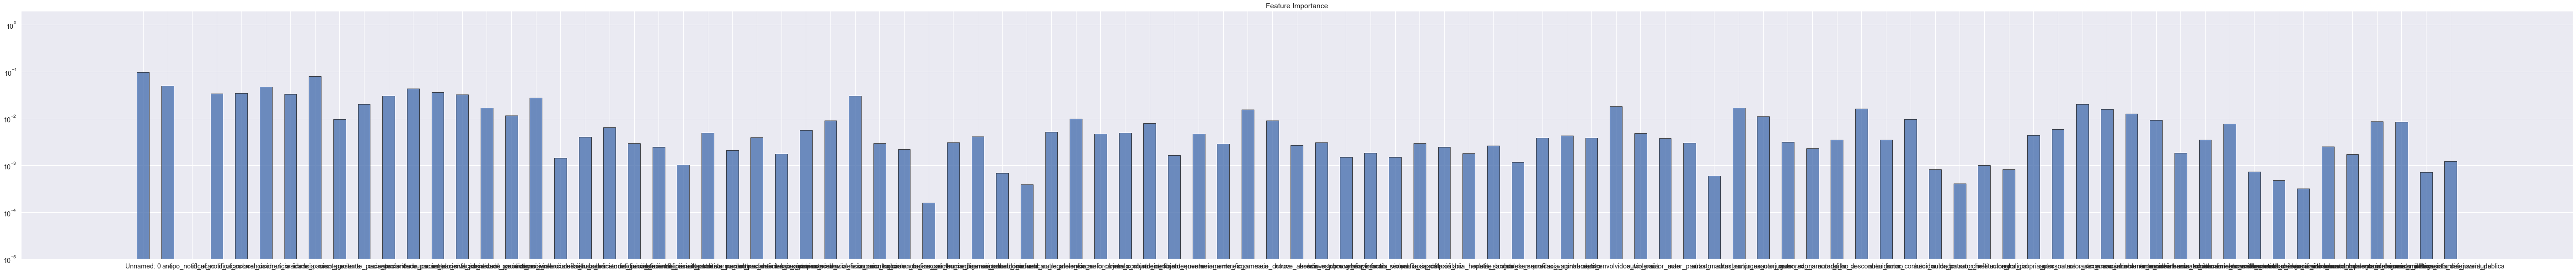

In [32]:
feature_imp = pd.DataFrame({'Feature': Xtreino.columns,'Importance': rf.feature_importances_})
f = plt.subplots(1, figsize=(100,10))
plt.bar(feature_imp.Feature, feature_imp.Importance, log=True, alpha=0.8, width=0.5, edgecolor='k')
plt.ylim(1e-5, 2)
plt.title('Feature Importance')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

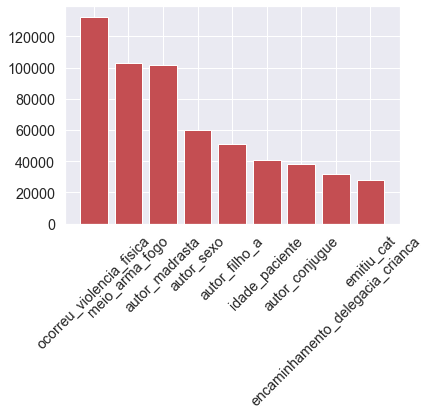

In [37]:
from sklearn.feature_selection import SelectKBest, f_regression
train_data = df.apply(pd.to_numeric).astype('float32')

kb = SelectKBest(score_func=f_regression, k=70)
kb.fit(train_data.loc[:, train_data.columns != 'outras_vezes_ocorrencia'], train_data.outras_vezes_ocorrencia)
indices = np.argsort(kb.scores_)[::-1]
selected_features = []
for i in range(10):
  selected_features.append(train_data.columns[indices[i]])
plt.figure()
plt.bar(selected_features, kb.scores_[indices[range(10)]], color='r', align='center')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

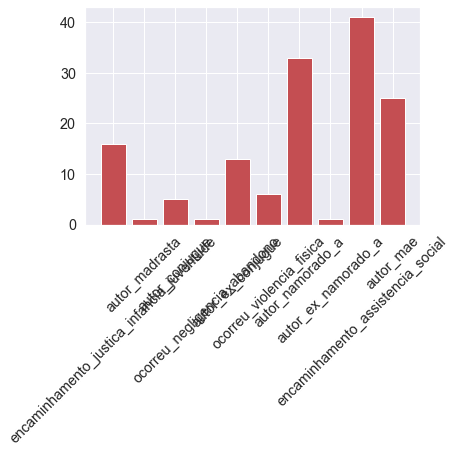

In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
train_data = df.apply(pd.to_numeric).astype('float32')
# model = XGBClassifier()
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
fit_rfe = rfe.fit(train_data.loc[:, train_data.columns != 'outras_vezes_ocorrencia'], train_data.outras_vezes_ocorrencia)
indices_rfe = np.argsort(fit_rfe.ranking_)
selected_features_rfe = []
for i in range(10):
    selected_features_rfe.append(train_data.columns[indices_rfe[i]])
selected_features_rfe
plt.figure()
plt.bar(selected_features_rfe, fit_rfe.ranking_[indices[range(10)]], color='r', align='center')
plt.xticks(rotation=45)

## Modelo de rede neural

In [ ]:
# modelo de regressão
# SGD como otimizador
modelo = tf.keras.Sequential([
  layers.Dense(64),
  layers.Dense(1)
])

modelo.compile(loss = tf.losses.MeanSquaredError(),
                      optimizer = tf.optimizers.SGD())

In [ ]:
# fit do modelo com callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.2)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)
callbacks = [lr_reducer,early_stopper]

history = modelo.fit(Xtreino,
                    Ytreino,
                    validation_data=(Xteste,Yteste), 
                    callbacks=callbacks,
                    epochs=5,
                    batch_size=64,
                    verbose=1)

In [ ]:
modelo.save('./pesos/')

In [ ]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [ ]:
modelo.summary()